# Machine Learning Engineer Nanodegree
## Model Evaluation & Validation
## Project: Predicting Boston Housing Prices


## Getting Started
In this project, we evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

In [ ]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

## Data Exploration
In this first section of this project, I will make a cursory investigation about the Boston housing data and provide my observations.


The main goal of this project is to construct a working model which has the capability of predicting the value of houses. Therefore, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Calculate Statistics
For your very first coding implementation, we will calculate descriptive statistics about the Boston housing prices. We use `numpy` to perform the necessary calculations. These statistics are in analyzing various prediction results from the constructed mode.

In [ ]:
# Minimum price of the data
minimum_price = np.amin(prices)

# Maximum price of the data
maximum_price = np.amax(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${}".format(minimum_price)) 
print("Maximum price: ${}".format(maximum_price))
print("Mean price: ${}".format(mean_price))
print("Median price ${}".format(median_price))
print("Standard deviation of prices: ${}".format(std_price))

### Feature Observation
We are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

Using our intuition and what we know about the features, we can try to come up with some hypothesis for the data:
1. An increase in the value of RM is going to increase the value of MEDV while having the opposite effect when decreasing RM. More rooms correlate with an increase of space in the home which adds to the price. 
2. An increase in the value of LSTAT is going to decrease the value of MEDV and have the opposite effect when decreasing the value of LSTAT. We can infer this because people that are considered lower class cannot afford high priced homes. Therefore, a neighborhood with a significant amount of lower class individuals will most likely have cheap housing.
3. The PTRATIO is a bit more interesting. One can assume that a lower ratio of students to teachers means that the schools in that area are funded well because they can afford more teachers. More funds for education usually means a wealthier neighborhood and therefore higher prices for homes. Therefore, we can hypothesize that the lower the PTRATIO, the higher the MEDV and the higher PTRATIO, the lower the MEDV.

We can further analyze and support our hypothesis about the correlations between our features by looking at the correlation heatmap matrix:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

cols = ['LSTAT', 'PTRATIO', 'RM', 'MEDV']
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f',
                annot_kws = {'size': 15},
                yticklabels=cols,
                xticklabels=cols)
plt.show()

The above matrix shows that there is a negative correlation between LSTAT and MEDV which means that as one value increase the other decreases. This is also seen between PTRATIO and MEDV. On the other hand, RM and MEDV have a positive correlation meaning as one value increases so does the other. Therefore, the correlation matrix further supports our hypothesis.

----

## Developing a Model

### Define a Performance Metric
In order to measure the quality of a model we need to quantify its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, we will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

In [ ]:
# Import and implement'r2_score'
from sklearn.metrics import r2_score


def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |


In [ ]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))


 The R2 score is the proportion of the variance in the dependent variable that is predictable from the independent variable. In other words:
* R2 score of 0 means that the dependent variable cannot be predicted from the independent variable.
* R2 score of 1 means the dependent variable can be predicted from the independent variable.
* R2 score between 0 and 1 indicates the extent to which the dependent variable is predictable. An 
* R2 score of 0.40 means that 40 percent of the variance in Y is predictable from X.

This can also be explained by looking at the equation of R^2:

$$R^2 = 1 - \frac{SSE}{SST} = \frac{SSR}{SST}$$

As seen in the figure above the equation for R^2 involves 1 - SSE/SST where SSE is the sum of squared errors of our prediction and SST is the total sum of squares or total variation. R^2 can also be represented as SSR/SST where SSR is the explained sum of squares and SST is the total sum of squares. Therefore, a really good model would have R^2 equal to 1 meaning SSR = SST or SSE = 0. Intuitively, this means that our model explains the variation of Y (SSR = SST) or in other words has no error (SSE = 0). A really bad model would have R^2 equal to 0 meaning SSR = 0 (model explains no variation) or in other words has SSE = SST (model is no better than a model representing the average). 

For this reason, one wants to maximize R^2 to be as close to 1 as possible. This is why the above score of 0.923 (92.3%) belonging to our five data point model captures the variation of the target variable. It captures 92.3% of the variation of the target variable.

### Shuffle and Split Data
Next we will use the Boston housing dataset and split the data into training and testing subsets. We will shuffle the data into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

In [ ]:
# Import 'train_test_split'
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets(80% training-20% testing)
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.20, random_state=40)

# Success
print("Training and testing split was successful.")

### Training and Testing (Benefits of Splitting a dataset)

It is essential to split our dataset into some ratio of training and testing subsets because we want to make sure that our model does not just 'memorize' the data. In other words, it's a method to prevent overfitting. If we were to test and train on the same dataset, then no valuable information would be gained when evaluating the performance of our model. Since we trained our model on that data, we expect it to do well on the same data. Furthermore, if we split the data in favor of the testing subset and leave little data for training, then our model may underfit the data and do poorly at predicting the testing subset. Therefore, it is essential to pay attention to the ratio of training and testing subsets to make sure that we can evaluate our model correctly.

----

## Analyzing Model Performance
In this section of the project, we will take a look at several models' learning and testing performances on various subsets of training data. Additionally, we will investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

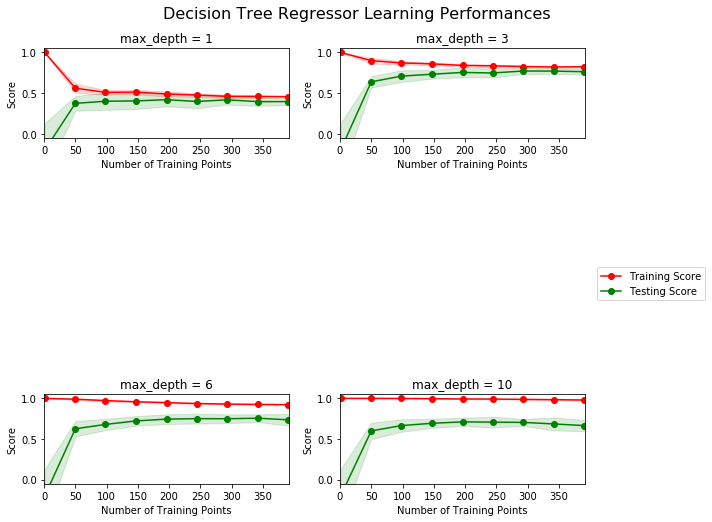

In [6]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Learning the Data

**Decision Tree Analysis**
1. The first graph with the maximum depth of 1 has both it's testing score and training score converge to about 0.5. Both training and testing scores begin to converge at 50 points and only change minimally as the number of training points increases after that. However, note that the training score decreases to convergence while the testing score increases. 
2. The second graph with the maximum depth of 3 has a similar situation to the first graph with convergence for both training and testing scores at 50 training scores. However, the training score minimally decreases as it converges while the testing score noticeably increases. Both scores converge to about 0.6.
3. The third graph with the maximum depth of 6 has an almost identical situation to the second graph.
4. The fourth graph with the maximum depth of 10 seems to have the testing score converge to approximately 0.6 as the number of training points increase. The converging of the testing score begins to happen after 50 points. The training score does not seem to change as the number of training points increase. 

Therefore, it appears that having more training points does not necessarily benefit the model. All graphs show that after 50 training points there appears to be little to no benefit to the performance of the model the number of training points increase.

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

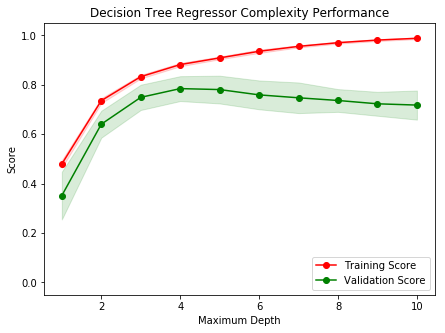

In [7]:
vs.ModelComplexity(X_train, y_train)

### Bias-Variance Tradeoff

Training the model with a maximum depth of 1, causes the model to suffer from high bias(underfitting). The low scores for training and validation illustrate high bias meaning that the model is too simple and cannot pick up the differences in the data very well. Training the model with a maximum depth of 10, causes the model to suffers high variance(overfitting). The training score and validation scores in the graphs do not seem to get close or converge to a similar score. The lack of similar convergence represents overfitting of the training data. Having high variance means that the model is not generalizing the data very well and is instead memorizing the data. Furthermore, the training score approaching 1 signifies that our model is just memorizing (overfitting) the training data. 

### Best-Guess Optimal Model

Visiting the graph above we can see that a maximum depth of 4 seems to result in a model that best generalizes. The score for validation increases up to depth 4 and then begins to decrease after. The decrease score means that more errors begin to happen as we increase the maximum depth after 4. Although the Training Score keeps increases after a maximum depth of 4, we can see overfitting beginning to happen since the validation score stays the same or can even be seen slightly decreasing.

-----

## Evaluating Model Performance
In this final section of the project, I will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Grid Search

The grid search is a way of systematically working through multiple combinations of hyperparameters tunes. Then cross-validating as it goes through each combination to determine which tune gives the best performance. The word 'grid' refers to a table (or grid) that is created with all the possible hyperparameters combinations to try to see which will best optimize the learning algorithm. For example, in SVC we can see whether a type of kernel combined with a high C value performs better or worse than another type of kernel with a low C value.

### Cross-Validation

Cross-validation is a technique used to evaluate a model by partitioning the original data into a training set to train the model and a test set to evaluate the model. K-fold is a type of cross-validation that allows us to use all of our data instead of prohibiting access to a subset of our data(testing data) and limiting ourselves to another subset(training data). In K-fold we randomly break our data into k pieces or k samples of equal size. Then we train our model k times(the 'fold'), each time using a different sample as our testing set and the remaining samples(k-1) for our training set. The final model comes from averaging the results. Note that this method does not perform well on uniformly distributed data(i.e., sorted data).

**Grid Search and K-fold**

K-fold can also provide benefits to grid search. Grid search hinges on splitting the data into three parts(Training, Validating, and Testing) which limits the data that we have for training. K-fold can allow us to use all of our data when using grid search which will prevent grid search from choosing hyperparameters that only work well in a subset of the data but not the rest.

### Fitting a Model
We will now train a model using the **decision tree algorithm**. We will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction.

In addition, we will implementation `ShuffleSplit()` for an alternative form of cross-validation. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. Check out [*this*](https://stackoverflow.com/questions/34731421/whats-the-difference-between-kfold-and-shufflesplit-cv) stackoverflow question for the differences between k-fold and shufflesplit.



In [13]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(X.shape[0], test_size = 0.20, random_state = 0)

    # Decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10]}

    # 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    grid = GridSearchCV(regressor, params, scoring = scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions

### Optimal Model

In [ ]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

** Hint: ** The answer comes from the output of the code snipped above.

**Answer: ** The optimal max_depth is 4 which is exactly the result I predicted in Question 6

### Question 10 - Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

* What price would you recommend each client sell his/her home at? 
* Do these prices seem reasonable given the values for the respective features? 

**Hint:** Use the statistics you calculated in the **Data Exploration** section to help justify your response.  Of the three clients, client 3 has has the biggest house, in the best public school neighborhood with the lowest poverty level; while client 2 has the smallest house, in a neighborhood with a relatively high poverty rate and not the best public schools.

Run the code block below to have your optimized model make predictions for each client's home.

In [10]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $411,096.00
Predicted selling price for Client 2's home: $219,961.54
Predicted selling price for Client 3's home: $921,900.00


**Answer: ** Client 1 should sell his home at 411,096.00 which is reasonable because they have a large number of rooms in their house, moderate poverty level, and a relatively small student-teach ration. Client 2 should sell his home at 219,961.54 which makes sense since he lives in the poorest neighboorhood, with the lowest funded education and only four rooms. Client 3 lives in the wealthiest neighboorhood, has the biggest house and has the most funded schools. These features are the reason why he should sell his home at 921,900.00.

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

**Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.**

In [11]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $411,417.39
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $413,334.78
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $402,531.82
Trial 10: $413,700.00

Range in prices: $29,438.89


### Question 11 - Applicability

* In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.  

**Hint:** Take a look at the range in prices as calculated in the code snippet above. Some questions to answering:
- How relevant today is data that was collected from 1978? How important is inflation?
- Are the features present in the data sufficient to describe a home? Do you think factors like quality of apppliances in the home, square feet of the plot area, presence of pool or not etc should factor in?
- Is the model robust enough to make consistent predictions?
- Would data collected in an urban city like Boston be applicable in a rural city?
- Is it fair to judge the price of an individual home based on the characteristics of the entire neighborhood?

**Answer: ** The constructed model should not be used in a real-world setting since the data is not only specific to a time-period but also a location. The prices of home change over time not only due to inflation but also due to other factors. The price of a house may be worth more or less depending on the change of conditions. There are also other factors to take into consideration, such as the location of the house or whether the house has multiple floors. Overall, the price of a house is dependent on many features that this model does not take into account and therefore would not be very reliable in a real-world setting. The data collected in an urban city like Boston will not be applicable in a rural city. This is due to many factors such as the different costs to live in each city or the amount of people that would want to live in a rural city versus a city like Boston. Furthermore, it may not be "fair" to judge the price of an individual home based on the characteristics of the entire neighborhood. However, according to data a neighborhood plays an important part in calculating the worth of a home.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.